In [1]:
import pandas as pd
import numpy as np

In [2]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score

In [5]:
"From kaggle competition evaluation metrix"
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d),g,d

In [10]:
xgb=XGBClassifier(
learning_rate =0.1,
n_estimators=1000,
max_depth=5,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27
)

In [11]:
final_data=pd.read_csv('Final_Data.csv')
req=final_data.columns
req=req[1:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2,shuffle=True)

In [12]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [4,5,6],
    'n_estimators': [500,800,1000]
}
best_param=GridSearchCV(estimator=xgb,
                       param_grid=params)
best_param.fit(train_x,train_y)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                  

In [13]:
best_param=best_param.best_estimator_
best_param.fit(train_x,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=800,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [14]:
import matplotlib.pyplot as plt

The Accuracy Score is 0.8705504863130452
The Precision is 0.7344329896907217
The recall is 0.7335255354200988
The f1 score is 0.7339789820729445
The area under curve 0.9323097794343222


Text(0.5, 1.0, 'ROC Curve')

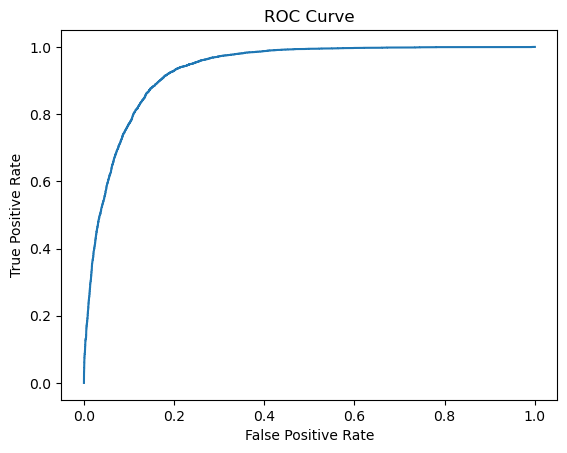

In [15]:
print("The Accuracy Score is {}".format(accuracy_score(best_param.predict(test_x),test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,best_param.predict(test_x),average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
pred_proba_y=best_param.predict_proba(test_x)
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y[:,1])
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


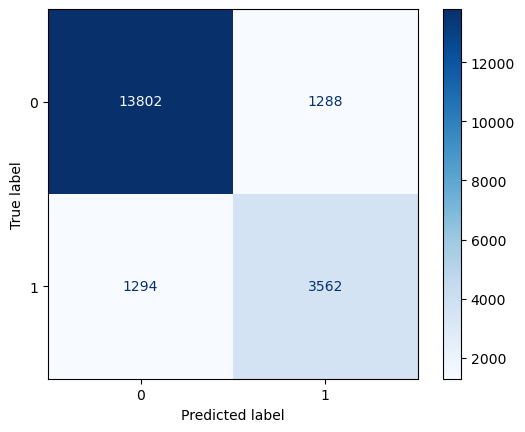

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(test_y,best_param.predict(test_x))
m=plot_confusion_matrix(best_param,test_x,test_y, cmap=plt.cm.Blues)
plt.show()

In [20]:
test_y_num=np.array(test_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(pred_proba_y[:,1],columns=['prediction'])

In [21]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8646111430605519
Top 4% capture 0.48702635914332787
Final eval metric 0.6758187511019399


In [39]:
final_data=pd.read_csv('Final_Data_new.csv')
req=final_data.columns
req=req[2:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2)

In [40]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [4,5,6],
    'n_estimators': [500,800,1000]
}
best_param=GridSearchCV(estimator=xgb,
                       param_grid=params)

In [41]:
best_param.fit(test_x,test_y)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                  

In [42]:
best_param=best_param.best_estimator_
best_param.fit(train_x,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

The Accuracy Score is 0.8672415521909155
The Precision is 0.7435146443514644
The recall is 0.7142282958199357
The f1 score is 0.7285772857728579
The area under curve 0.9291888774870211


Text(0.5, 1.0, 'ROC Curve')

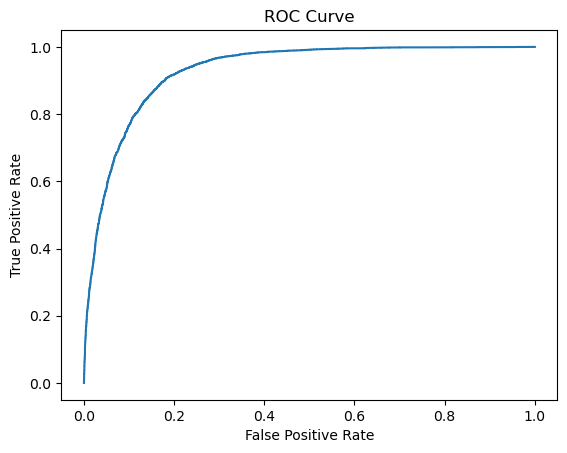

In [43]:
print("The Accuracy Score is {}".format(accuracy_score(best_param.predict(test_x),test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,best_param.predict(test_x),average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
pred_proba_y=best_param.predict_proba(test_x)
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y[:,1])
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [44]:
test_y_num=np.array(test_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(pred_proba_y[:,1],columns=['prediction'])

In [47]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8583689273914131
Top 4% capture 0.4754823151125402
Final eval metric 0.6669256212519766
